# Bilimsel Programlamaya Kolay Başlangıç - III

Bilimsel Programlama'ya Kolay Başlangıç serisinin [ilk yazısında](https://www.veridefteri.com/2018/08/29/bilimsel-programlamaya-kolay-baslangic-1/) Hazırlık, Hesaplama ve Sonuçları Görselleştirme adımlarından bahsetmiş ve bunları serbest düşüş problemine uygulamıştık. [İkinci yazıda](http://www.veridefteri.com/2018/09/03/bilimsel-programlamaya-kolay-baslangic-2/) ise Hesaplama adımından sonra Veri/Hata Analizi adımını eklemiş ve eğik atış problemini Euler sayısal metodu ile de hesaplayarak hatamızı incelemiştik. Lakin tüm bunları Python'un kendi matematik kütüphanesi olan `math` ile gerçekleştirdik.

Serinin üçüncü yazısında ise `math`'a oranla (genellikle) daha hızlı ve çok daha yetenekli olan `numpy` ve sonrasında da bunun üstüne bir kat daha çıkarak `scipy` kütüphanelerine terfi edeceğiz ve kolay yoldan bir ikinci derece diferansiyel denklem çözeceğiz. Bunun için Eğik Atış problemi yerine, nonlineer bir problem olan "iki cisim problemini", yani Dünya'nın çevresindeki uyduların dinamiğini kullanacağız.

İki cisim problemi en genel haliyle kütle çekiminden kaynaklanan ivmeden ibaret:

$ \ddot{\vec{r}} = - \frac{\mu}{r^3} \vec{r}  $  

Burada $\vec{r}$ konum vektörünü, $r$ konum vektörünün büyüklüğünü ve $ \ddot{\vec{r}} $ konum vektörünün zamana göre ikinci türevini, ya da daha bilindik adıyla _ivmeyi_ gösteriyor. $\mu$ ise pek tanıdık değil, ama aslında Dünya'nın kütleçekim sabitini gösteriyor. Örneğin Ay'ın ya da bir uydunun, Dünya'nın çevresinde dönerken gelecekteki konum ve hızını bulabilmek için, başlangıçtaki konum ve hızı bu ivmenin integralini alarak ilerleteceğiz. İntegral lafını duyunca tüyleriniz diken diken olduysa korkmayın; integrali biz almayacağız, _bilgisayar_ alacak. 

Matematiğe gelmeden önce, işin kalbindeki veri yapısı olan `ZamanKonumHız` sınıfının `numpy` kullanan yeni sürümüne bakalım:

In [18]:
# sonradan gerekecek kütüphaneleri çağır
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Kütleçekimi Sabiti [m^3/s^2]
muDünya = 398600.5*1E9    

class ZamanKonumHız:
   """
    Zaman, 2D konum ve 2D hız değerlerini içeren vektör sınıfı
   """
   t = 0
   r = np.zeros(2)
   v = np.zeros(2)

   def __init__(self, t0, rx0, ry0, vx0, vy0):
       """
       Zaman, konum ve hızı ilk değerleriyle başlatır.
       
       Arguments:
           t0  {float} -- zaman (s)
           rx0 {float} -- x ekseninde konum (m)
           ry0 {float} -- y ekseninde konum (m)
           vx0 {float} -- x ekseninde hız (m/s)
           vy0 {float} -- y ekseninde hız (m/s)
      """
       self.t = t0      
       self.r = np.array([rx0, ry0])
       self.v = np.array([vx0, vy0])

      
   def konumBüyüklüğü(self):
       """Konum vektörünün büyüklüğünü döndürür
               
        Returns:
           float -- Konum vektörünün büyüklüğü ($m$)
       """
       return np.linalg.norm(self.r)

   def hızBüyüklüğü(self):
       """Hız vektörünün büyüklüğünü döndürür
        
        Returns:
           float -- Hız vektörünün büyüklüğü ($m^2/s^2$)
        """
       return np.linalg.norm(self.v)

   def spesifikEnerji(self):
       """
       Spesifik enerjiyi hesaplar.

       Spesifik enerji birim kütleye düşen enerji olarak tanımlanır

       $e =  \frac{1}{2} v^2 - \frac{\mu}{r} $
       
       Returns:
           float -- spesifik enerji ($m^2/s^2$)
       """
       return 0.5*self.v.dot(self.v) - muDünya/self.konumBüyüklüğü()

   def ivme (self, mu=muDünya):
       """
       İvmeyi hesaplar
       
       İki cisim problemine göre bu konum ve hıza ait ivmeyi hesaplar.
       
       Keyword Arguments:
           mu {float} -- Kütleçekimi Sabiti (m^3/s^2) (default: {muDünya})
       
       Returns:
           {ndarray} -- İvme vektörü ($m/s^2$)
       """
       return -mu/np.power(self.konumBüyüklüğü(), 3) * self.r

Öncelikle, eğik atış problemindeki sınıfa göre ne kadar az şeyin değiştiğine dikkatinizi çekmek isterim. İyi bir sınıf tasarımı sayesinde, çok daha başka bir problemde bile eski veri yapılarımızı kullanmayı başardık.

`numpy`'a geçişte konum ve hız vektörleri olan`r` ve `v`'yi minik ikili array'ler haline getirdik. Bu durum okunaklılığı kaçınılmaz olarak azaltıyor (`ry` mi daha açık, `r[1]` mi?), ama bize `numpy`'ın kuvvetli vektör işlemlerinin kapılarını açtığı için sonuçta çok faydalı.

Bununla birlikte, `__init__` vektörü hala `t0, rx0, ry0, vx0, vy0` değişkenlerini tek tek girmemizi istiyor. Bunları neden vektör olarak vermiyoruz diye merak edebilirsiniz. Bunu yapabiliriz, ama o zaman girdideki her bir vektörün iki elemanlı olduğunu kontrol etmemiz, sonra da ikiden fazla ya da eksik eleman çıkarsa ne yapacağımıza karar vermemiz gerekli. Bu nedenle, daha kodu yazarken, bu tür girdilerde ve arayüzlerde yapılabilecek hataları öngörüp buna göre önlem almak orta vadede sizi (ve kodlarınızı kullanacak başka kişileri) hatadan korur. Bu örnekte, bu sınıfı kullanacak kişileri doğru sayıda veri vermeye zorlayarak sınıfın hatalı şekilde başlatılmasının önüne geçtik. 

Bunun yanı sıra vektör büyüklüklerini hesaplama işini de `numpy`'ın `linalg.norm` metoduna emanet ettik. Böylece, örneğin bu sınıfı başka bir zaman 3 boyut için kullanmak istediğimizde bu kısımları değiştirmemiz gerekmeyecek, şimdiden hazırız.

Bu arada yorumları daha detaylı yazmaya başladık ve parametrelerin birimlerini de özellikle belirttik. Birimler ve arayüzler mühim, 1999 yılında Mars Climate Orbiter tam da bu yüzden [kaybedildi](https://www.wired.com/2010/11/1110mars-climate-observer-report/)!

Ekledğimiz `ivme` metodu da dikkatli gözlerden kaçmamıştır. Böylece ivme hesaplamasını `ZamanKonumHız` sınıfının bir yeteneği olarak tanımladık.

Son olarak `spesifikEnerji` adlı bir metod da ekledik. Spesifik enerji birim kütleye düşen enerji olarak tanımlanabilir:   
$e =  \frac{E}{m} = \frac{1}{2} v^2 - \frac{\mu}{r} $

Spesifik enerjinin bizim için önemi şurada: _İki cisim probleminde enerjinin korunup korunmadığına bakarak hatamızı kontrol edebiliriz_. Zira fizik bize enerjinin korunması gerektiğini söylüyor, enerji korunumundan ne kadar uzaklaşırsak yaptığımız hata da o kadar artmış demektir. Bunu da birazdan kullanacağız. 

Bu sınıfı uzun uzadıya anlattığım için şimdiden sıkılmaya başlayan arkadaşlara not: Genellikle bilimsel programlamada bu tarz temel veri yapılarını içeren sınıflar çok kullanılır. Bunları ne kadar özenle hazırlar ve yetenekler kazandırırsanız ileride hayatınız o kadar kolaylaşır.

Hazırlık kısmının diğer bileşenleri ise geçen yazıdan tanıdık gelecektir:

In [19]:
# Kütleçekimi Sabiti [m^3/s^2]
muDünya = 398600.5*1E9

# başlangıç zamanı
t0 = 0
# bitiş zamanı (sn)
tSon = 6000 
# adım büyüklüğü (sn)
tAdım = 5

# başlangıç konum ve hız
pvt0 = ZamanKonumHız(t0, 0, 7000*1E3, 7.5*1E3, 0)

İşin matematik kısmını bu örnekte fonkisyonlara toplayacağız. Bu tür fonksiyonlar ve bu fonksiyonları çağıran daha da başka fonksiyonlar [Matruşka Bebekleri](https://en.0wikipedia.org/wiki/Matryoshka_doll) gibi iç içe geçerek kodun çok daha derli toplu ve daha önemlisi _yeniden kullanılabilir_ olmasını sağlıyorlar. Aynı kodları defalarca yazmak hem zahmetli hem de hata bulma ve yeni işlev eklemeyi son derece zorlaştırıyor.

Bir sonraki adımda, bir önceki yazıda değndiğimiz temel fonksiyonları da `numpy` ile tekrar yazacağız. Yorumlar daha detaylı hale geldi, artık veri tipi bile yazıyor ama temel yapı aynı.

In [20]:
def eulerZamanKonumHız(dt, pvt, mu=muDünya):
    """
    Verilen bir dt adım büyüklüğü kadar zaman konum ve hızı Euler Metodu ile ilerletir.
    
    Arguments:
        dt {float} -- adım büyüklüğü (s)
        pvt {ZamanKonumHız} -- t zamanında zaman konum hız
        mu {float} -- Kütleçekimi Sabiti (m^3/s^2) (default: {muDünya})

    Returns:
        {ZamanKonumHız} -- t+dt zamanında zaman konum hız
    """
    a = pvt.ivme(mu)

    tYeni  = pvt.t + dt
    rYeni  = pvt.r + pvt.v * dt
    vYeni  = pvt.v + a * dt

    return ZamanKonumHız(tYeni, rYeni[0], rYeni[1], vYeni[0], vYeni[1])


def hesapDöngüsüEuler(pvt0, tAdım, tSon):
    """
    Euler sayısal integrasyon metoduyla konum ve hız değerleri listesini hesaplar.

    Arguments:
        tAdım {float} -- adım büyüklüğü (s)
        pvt0 {ZamanKonumHız} -- başlangıç zamanında zaman konum hız
        tSon {float} -- bitiş zamanı (s)

    Returns:
        list {ZamanKonumHız} --  her bir zaman adımı için zaman konum hız değerlerini içeren liste
    """
    # ilk değerleri doldur
    numPvtList = [pvt0]

    t = numPvtList[0].t + tAdım
    while t<=tSon:
        pvtNum = eulerZamanKonumHız(tAdım, numPvtList[-1])
        numPvtList.append( pvtNum )

        t += tAdım
    
    return (numPvtList)

`eulerZamanKonumHız` adlı yapı içinde iki cisim problemine ait ivmeyi hesaplıyoruz. Sonra da konumu bilinen en son hızı sabit kabul ederek, hızı da hesaplanan ivmeyi sabit kabul ederek ilerletiyoruz. Burada yaptığımız şey aslında _kısa bir zaman adımı için_ integral almak, ama bunu _sayısal_ olarak yaptığımız için son derece kolay şekilde hallediyoruz. Tabii ödediğimiz bedel "tam olarak doğru ve hatasız" değil, ancak yaklaşık bir hesaplama yapmak. `hesapDöngüsüEuler` adımı içinde ise bu küçük zaman adımlarını bir döngü içinde defalarca hesaplayarak `tSon` değerine kadar tüm konum ve hız çiftlerini elde ediyoruz.

Bütün matematiği yukarıda anlatılan fonkisyonlara paketlediğimiz için asıl işi yapacak kod sadece ve sadece 1 (bir) satıra indi:

In [21]:
# Euler sayısal integrasyon verisini hesaplayan döngüyü çalıştır
eulPvtList = hesapDöngüsüEuler(pvt0, tAdım, tSon)

Bu çok klasik bir "işi fonksiyonda yap, `return` ile sonucu döndür ve bu sonucu bir değişkene ata" diyebileceğim (muhtemelen birilerinin çoktan bir _pattern_ adı ile tanımladığı) bir yapı. Başkalarının kodlarını incelerken sıkça karşınıza çıkacak, sonra siz de bol bol kullanacaksınız.

Konum ve hız grafiklerine bakalım:

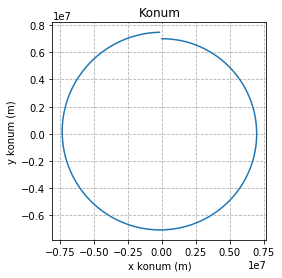

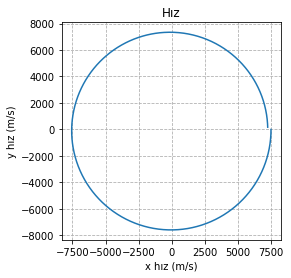

In [22]:
# konum grafiği 
plt.plot( [pvt.r[0] for pvt in eulPvtList], [pvt.r[1] for pvt in eulPvtList], label="Euler (" + str(tAdım) + " s)")

plt.title("Konum")
plt.xlabel("x konum (m)")
plt.ylabel('y konum (m)')

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show()

# hız grafiği
plt.plot( [pvt.v[0] for pvt in eulPvtList], [pvt.v[1] for pvt in eulPvtList], label="Euler (" + str(tAdım) + " s)")

plt.title("Hız")
plt.xlabel("x hız (m/s)")
plt.ylabel("y hız (m/s)")

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show()

Grafikleri oluşturduğumuz kod [bir önceki yazıdakinden](http://www.veridefteri.com/2018/09/03/bilimsel-programlamaya-kolay-baslangic-2/) pek farklı değil, ama eklediğimiz iki satırla eksenlerin ölçeklerini birbirine eşitlediğimize dikkat edin. Böylece daha gerçekçi bir fiziksel gösterim elde ettik.


Grafiklere yakından bakınca bir tuhaflık göze çarpıyor: ilk grafikte "saat 12" konumundan başlayıp saat yönünde dönüyoruz, ama başladığımız yere geri dönemiyoruz. Aynı durum hız için de geçerli. Normalde iki cisim problemi _periyodik_ bir problem, enerji korunuyor ve bu nedenle de -gördüğümüz grafiklerin aksine- başladığımız konum ve hıza geri dönmeyi bekliyoruz. Diğer bir deyişle, potansiyel ve kinetik enerjinin toplamının değişmemesi gerekiyor. Bizim çözümümüzde enerjinin korunup korunmadığını test etmek için, başlangıç konum ve hızından hesapladığımız "referans" enerji değerinden, her yeni zaman için ne kadar sapıldığını kontrol etmemiz yeterli:

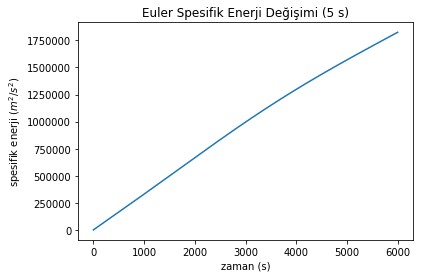

In [23]:
# enerji grafikleri

#referans değer - tüm farklar bu değere göre hesaplanacak
spEnerjiRef = pvt0.spesifikEnerji()

plt.title("Euler Spesifik Enerji Değişimi (" + str(tAdım) + " s)")
plt.xlabel("zaman (s)")
plt.ylabel(r"spesifik enerji ($m^2/s^2$)")

plt.plot( [pvt.t for pvt in eulPvtList], [pvt.spesifikEnerji()-spEnerjiRef for pvt in eulPvtList], label="Euler (" + str(tAdım) + " s)")

plt.show()

Görünüşe göre spesifik enerji lineer olarak artıyor ve bu artış duracakmış gibi de görünmüyor. Anlaşılan o ki, Euler ilerleticisi _enerjiyi korumuyor_. Adım büyüklüğünü azaltırsak hatanın da azalacağından daha önce bahsetmiştik. O halde 1, 5 ve 10 saniye için duruma bir göz atalım:

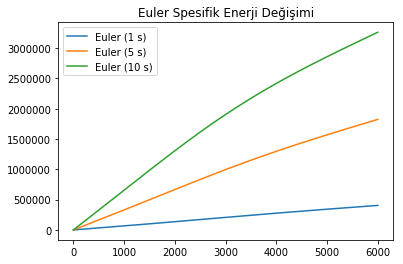

In [24]:
# adım büyüklüğü (sn)
tAdım5  = 5
tAdım10 = 10
tAdım1  = 1

# Euler sayısal integrasyon verisini hesaplayan döngüyü çalıştır
eulPvtList5  = hesapDöngüsüEuler(pvt0, tAdım5, tSon)
eulPvtList10 = hesapDöngüsüEuler(pvt0, tAdım10, tSon)
eulPvtList1  = hesapDöngüsüEuler(pvt0, tAdım1, tSon)

# enerji grafikleri

plt.title("Euler Spesifik Enerji Değişimi")

plt.plot( [pvt.t for pvt in eulPvtList1], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList1], label="Euler (" + str(tAdım1) + " s)")
plt.plot( [pvt.t for pvt in eulPvtList5], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList5], label="Euler (" + str(tAdım5) + " s)")
plt.plot( [pvt.t for pvt in eulPvtList10], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList10], label="Euler (" + str(tAdım10) + " s)")

plt.legend(loc=2)

plt.show()

Gerçekten de, adım büyüklüğü azaldıkça enerjideki artış yavaşlıyor. Yani adım büyüklüğünü ne kadar azaltırsak enerjinin korunumuna o oranda yaklaşıyoruz, haliyle konum ve hız hatamız da azalıyor. Teorik olarak, adım büyüklüğü sıfıra giderken enerji hatamızı da sıfırlayabiliriz! Gerçekte, başımıza dert olan kayan nokta hataları nedeniyle hatayı belli bir değerin altına indirmek mümkün değil.

Bu da sayısal modellerin, neden gerçek matematiksel modellerin yerini almakta zorlanacağını bize anlatıyor - tam matematiksel modeli elde edilemeyen, diferansiyel denklemi çözülemeyen ağır problemleri tenzih ediyorum elbette. Zira Euler ya da Runge-Kutta gibi matematiksel modeller fiziksel gerçekliği değil, sadece _problemin fiziğini ifade eden diferansiyel denklemlerin çözümünü_ modellemeye yarıyor. Enerjinin ya da momentumun korunumunu da modellemek için, bunun için özelleşmiş matematiksel modeller gerekiyor.

İşin yazılım tarafına baktığınızda ise, bu tür testlerle modellerinizin doğruluğunu ve nasıl davrandığını, istediğiniz doğruluğa ulaşmak için adım büyüklüğünü nasıl seçmeniz gerektiğini kestirebilirsiniz. Ya da enerjinin korunumu en ufak sorunda bozulan hassas bir denge olduğu için, sayısal integrasyon algoritmanıza bir _modül testi_ olarak yazabilirsiniz. İşler yeterince büyüdüğünde, yazılımınızın bir köşesinde bir şeyleri değiştirirken başka bir köşesinde bir şeyleri kırıp dökmek çok kolay olduğu için, bu tür testleri yazıp düzenli olarak çalıştırdığınızda yaptığınız hangi değişikliğin ortalığı karıştırdığını bulmak çok kolay olacaktır.

Buraya kadar `numpy` kullanımına basit bir giriş yapmıştık, şimdi ise daha ileri matematiksel yöntemleri içeren `scipy`'a bir göz atalım. Yapmaya çalıştığımız "ivmenin nümerik integrasyonu" işi, aslında bir "ikinci derece diferansiyel denklem çözümü" ile eşdeğer. Konumun zamana göre ikinci türevi olan ivme diferansiyel denklemini analitik olarak çözebilseydik, konum ve hız vektörlerinin geçmiş ve gelecekteki tüm değerlerini bulabilirdik. Lakin bunu analitik olarak çözmeye hiç niyetimiz yok - işi bilgisayar yapabilecekken biz niye uğraşalım ki?

`scipy` bu tür diferansiyel denklemleri çözmek için bize `integrate` paketi altında `solve_ivp` adlı kütüphaneyi sunuyor. Bu kütüphane altındaki metodlarla diferansiyel denklemleri sayısal metodlarla kolayca çözebiliriz. Ancak öncelikle denklemleri bu yöntemlerin anlayacağı halde yazmamız gerekiyor, diğer bir deyişle ikinci derece diferansiyel denklemi iki tane birinci derece diferansiyel denklem haline getirmemiz gerekiyor. Öncelikle kullanacağımız ara değişkenleri belirleyelim:

$ \vec{y_1} = \frac{d\vec{r}}{dt} = \dot{\vec{r}}  $  
$ \vec{y_2} = \vec{r}  $  

Şimdi de ikinci derece diferansiyel denklemimizi bu yeni değişkenler cinsinden yazalım:  
$ \dot{\vec{y_2}} = \frac{d\vec{y_2}}{dt} = \vec{y_1} $  
$ \dot{\vec{y_1}} = \frac{d\vec{y_1}}{dt} = - \frac{\mu}{(y_2)^3} \vec{y_2}  $  

Böylece ikinci derece diferansiyel denklemimiz iki tane birinci derece diferansiyel denkleme indirgendi ve `scipy`'ın çözebileceği hale geldi.

Yukarıda olan biteni kod halinde yazmak zor değil:

In [25]:
from scipy.integrate import solve_ivp


def odeDiffDenklem(t, y, mu=muDünya):
    """
    İki cisim problemi için diferansiyel denklem setini tanımlar.
    
    Arguments:
        t {float} -- başlangıç zamanı (s)
        y {ndarray} -- konum (m) ve hızı (m/s) içeren 1B, 4 elemanlı vektör [r_x r_y v_x v_y]


    Returns:
        {ndarray} -- konum ve hız diferansiyel denklemlerini (hız (m/s) ve ivmeyi(m/s^2)) içeren 
        1B, 4 elemanlı vektör [v_x v_y a_x a_y]
    """
    r = np.sqrt(y[0]**2 + y[1]**2)

    dy0 = y[2]
    dy1 = y[3]
    dy2 = -(mu / (r**3)) * y[0]
    dy3 = -(mu / (r**3)) * y[1]
    
    return [dy0, dy1, dy2, dy3]

`odeDiffDenklem` zaman ile konum-hız vektörünü alıyor (aslında yerçekimi ivmesini de alıyor ama maalesef henüz yeni çıkmış olan `solve_ivp` paketi bu değerin dışarıdan atanmasını kabul etmiyor).

Yukarıdaki metodla tanımlanan diferansiyel denklem setini çözen kod da zor görünüyor, ama aslında değil:

In [26]:

def odeÇözümü(pvt0, tAdım, tSon, çözücüTipi = 'RK45'):
    """
    Scipy ODE sayısal integrasyon metodlarıyla konum ve hız değerleri listesini hesaplar.

    Arguments:
        tAdım {float} -- adım büyüklüğü (s)
        pvt0 {ZamanKonumHız} -- başlangıç zamanında zaman konum hız
        tSon {float} -- bitiş zamanı (s)
        çözücüTipi {string} -- ODE çözücüsünün tipi ('RK45', 'RK23', 'Radau', 'BDF', 'LSODA')

    Returns:
        list {ZamanKonumHız} --  her bir zaman adımı için zaman konum hız değerlerini içeren liste
    """

    # adımSayısı ve zaman listesini oluştur
    adımSayısı = (tSon-pvt0.t)/tAdım + 1
    zamanListesi = np.asarray(np.linspace(pvt0.t, tSon, num = adımSayısı, endpoint=True))
    
    # diff denklem başlangıç değerlerini oluştur
    diffIlkDeğer = np.asarray(np.concatenate([pvt0.r, pvt0.v]))
    
    # diff denklemi başlangıç zamanından son zamana dek çöz
    diffDenkÇözüm = solve_ivp(odeDiffDenklem, [pvt0.t, tSon], diffIlkDeğer, method=çözücüTipi, dense_output=True) 
    
    # zaman listesine karşılık gelen değerleri oluştur
    cozumListesi = diffDenkÇözüm.sol.__call__(zamanListesi)
    
    # sonuç listesini başlat
    numPvtList = []

    # Listeyi objelere dönştür
    for i in range(len(zamanListesi)):
        pvArray = cozumListesi[:, i]
        numPvtList.append( ZamanKonumHız(zamanListesi[i], pvArray[0], pvArray[1], pvArray[2], pvArray[3]) )

    return (numPvtList)

`odeÇözümü`, başlangıç ZamanKonumHız nesnesini, adım büyüklüğünü ve son zaman adımını alıyor. Buraya kadarki kısmı Euler ile benzer. Ancak buna ek olarak kullanılacak diferansiyel denklem çözüm yöntemini de alıyor. Varsayılan değer olan `RK45`, 4. derece bir çözücü kullanarak adım büyüklüğünü belirleyen ama asıl çözüm için 5. derece kullanan bir _Adaptif Runge-Kutta_ yöntemi. Çok profesyonel olmasa da birçok öğrencinin projelerinde iş görecek bir diferansiyel denklem çözücüsü. Bu yöntem, hatayı belli bir seviyenin altında tutacak şekilde kendi adım büyüklüğünü belirleyecek kadar da akıllı. Ancak biz her `tAdım` değerinde bir çıktı almak istiyoruz. Bu nedenle, her `tAdım` aralıkla çıktı alınacak zamanların bir listesini oluşturuyoruz.

`solve_ivp` satırı aslında denklem setinin çözüldüğü satır - bir döngü bile yok, her şey sessiz sedasız içeride hallediliyor. Bu çözücüye diferansiyel denklem setini içeren metodu, başlangıç ve bitiş zamanlarını, ilk konum ve hızı ve çözücü tipini yolluyoruz. Bir sonraki adımda ise zaman listesine karşılık gelen ara çözümleri oluşturuyoruz. Biz `diffDenkÇözüm.sol.__call__(zamanListesi)` komutunu yazdığımızda arka tarafta interpolasyon algoritmaları bizim istediğimiz zamanlara karşılık gelen noktaları oluşturuyor. Son kısımda ise elde ettiğimiz bu çözüm setini `ZamanKonumHız` nesnelerine dolduruyoruz.

Sadece bu iki satır ile, oturup yazmaya üşeneceğimiz (ben benzerlerini yazdım, oradan biliyorum), yüzlerce satırlık koda karşılık gelen işlevselliği kolaylıkla elde edebiliyoruz. `scipy` sayesinde elbette!

O halde bunları çağırarak problemi çözen koda bakalım:

In [27]:
# başlangıç zamanı
t0 = 0
# bitiş zamanı (sn)
tSon = 6000 
# adım büyüklüğü (sn)
tAdımEuler_1  = 5
tAdımEuler_2  = 1
tAdımODE = 60
çözücüTipi = 'RK23'

# başlangıç konum ve hız
pvt0 = ZamanKonumHız(t0, 0, 7000*1E3, 7.5*1E3, 0)


# Euler sayısal integrasyon verisini hesaplayan döngüyü çalıştır
eulPvtList5  = hesapDöngüsüEuler(pvt0, tAdımEuler_1, tSon)
eulPvtList1  = hesapDöngüsüEuler(pvt0, tAdımEuler_2, tSon)

çözücüPvtList = odeÇözümü(pvt0, tAdımODE, tSon, çözücüTipi)

/home/egemen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Diferansiyel denklem çözücüsü için 60 saniyelik bir çıktı adım büyüklüğü kullandık, ama bu seferlik kullanacağımız 3. derece Runge-Kutta (`RK23`) yönteminde de adım büyüklüğü otomatik olarak, integrasyon algoritması tarafından belirleniyor. Bakalım `RK23` kullanarak bulduğumuz sonuçlar küçük adımlara sahip Euler yöntemlerinden daha mı iyi çıkacak? 

Bu sorunun yanıtı için grafikleri oluşturmamız gerek:

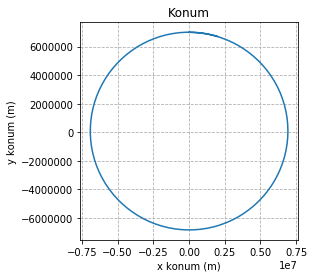

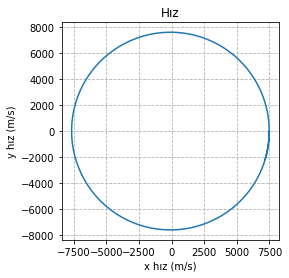

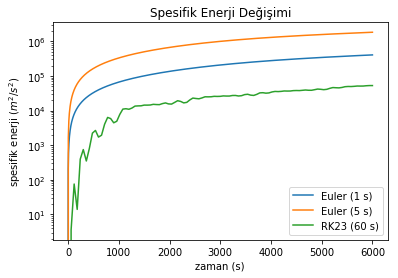

In [28]:
# konum grafiği
plt.plot( [pvt.r[0] for pvt in çözücüPvtList], [pvt.r[1] for pvt in çözücüPvtList], label=çözücüTipi + " (" + str(tAdımODE) + " s)")

plt.title("Konum")
plt.xlabel("x konum (m)")
plt.ylabel('y konum (m)')

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show()

# hız grafiği
plt.plot( [pvt.v[0] for pvt in çözücüPvtList], [pvt.v[1] for pvt in çözücüPvtList], label=çözücüTipi + " (" + str(tAdımODE) + " s)")

plt.title("Hız")
plt.xlabel("x hız (m/s)")
plt.ylabel("y hız (m/s)")

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show() 

# enerji grafikleri

#referans değer - tüm farklar bu değere göre hesaplanacak
spEnerjiRef = pvt0.spesifikEnerji()

plt.title("Spesifik Enerji Değişimi")
plt.xlabel("zaman (s)")
plt.ylabel("spesifik enerji ($m^2/s^2$)")
plt.yscale('log')

plt.plot( [pvt.t for pvt in eulPvtList1], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList1], label="Euler (" + str(tAdımEuler_2) + " s)")
plt.plot( [pvt.t for pvt in eulPvtList5], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList5], label="Euler (" + str(tAdımEuler_1) + " s)")
plt.plot( [pvt.t for pvt in çözücüPvtList], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in çözücüPvtList], label=çözücüTipi + " (" + str(tAdımODE) + " s)")

plt.legend(loc=4)

plt.show()

Öncelikle konum ve hız grafiklerini göstermek için kullandığımız RK23'ün hiç fena performans göstermediği anlaşılıyor - başladığımız yere iyi kötü dönmeyi başarmışız.

Yöntemler arasındaki uçurum nedeniyle enerji değişim grafiğini log ölçeğinde çizdirdik, aslında tüm yöntemler için artış lineer. Log kısmını kapatıp bunu siz de görebilirsiniz. Enerji grafiklerine bakınca, `RK23`'ün, 1 saniye adım büyüklüğüne sahip Euler'in sadece onda biri kadar enerji hatası yaptığı görülüyor. Yani `scipy`'ın yöntemleri bizim uzun uzadıya yazdığımız kodlardan çok daha iyi sonuç veriyor. Çıkarılacak sonuç çok açık, tekerleği yeniden keşfetmenin gereği yok - tabii `scipy`'ın sunduklarından daha iyi algoritmalar kullanmak durumundaysanız iş başka.

Yazdığımız `odeÇözümü` metodunda pek hoş olmayan bir kısım var: metoda çözücü adını `string` olarak yolluyoruz. Ancak kafamıza göre bir string değeri yollamamız mümkün değil, zira `solve_ivp` tarafından kabul edilen sadece birkaç çözücü var. Bu yöntem bizi hataya fazlasıyla açık hale getiriyor. Bunu çözmenin pratik bir yolu `enumerator` adı verilen mini mini veri depoları. Öncelikle enum içinde olası tüm değerleri (yani integrasyon algoritması tiplerini) belirliyoruz. Örneğin _adı_, yani `çözücüTipi.name` değeri RADAU olan bir parametremiz var. Bunun `çözücüTipi.value` ile sorgulanan _değeri_ 'Radau' ile ifade edilen string. Böylece parametre adları ve buna karşılık gelen değerlerden mini bir tablo oluşturmuş oluyoruz.

In [29]:
from enum import Enum

class ODEÇözücüTipi(Enum):
    """
    solve_ivp integrasyon tipleri
    """
    RK45 = 'RK45'
    RK23 = 'RK23'
    RADAU = 'Radau'
    BDF = 'BDF'
    LSODA = 'LSODA'

Bir sonraki adımda da `odeÇözümü` metodunda buna uygun küçük bir değişiklik yapıyoruz - metodumuzun kullanıcısını yukarıda belirlediğimiz tablodaki parametreler arasında bir tercih yapmaya zorluyoruz. 

In [30]:
def odeÇözümü(pvt0, tAdım, tSon, çözücüTipi = ODEÇözücüTipi.RK45):
    """
    Scipy ODE sayısal integrasyon metodlarıyla konum ve hız değerleri listesini hesaplar.

    Arguments:
        tAdım {float} -- adım büyüklüğü (s)
        pvt0 {ZamanKonumHız} -- başlangıç zamanında zaman konum hız
        tSon {float} -- bitiş zamanı (s)
        çözücüTipi {ODEÇözücüTipi} -- ODE Çözücü Tipi

    Returns:
        list {ZamanKonumHız} --  her bir zaman adımı için zaman konum hız değerlerini içeren liste
    """

    # adımSayısı ve zaman listesini oluştur
    adımSayısı = (tSon-pvt0.t)/tAdım + 1
    zamanListesi = np.asarray(np.linspace(pvt0.t, tSon, num = adımSayısı, endpoint=True))
    
    # diff denklem başlangıç değerlerini oluştur
    diffIlkDeğer = np.asarray(np.concatenate([pvt0.r, pvt0.v]))
    
    # diff denklemi başlangıç zamanından son zamana dek çöz
    diffDenkÇözüm = solve_ivp(odeDiffDenklem, [pvt0.t, tSon], diffIlkDeğer, method=çözücüTipi.value, 
                                                                  dense_output=True, rtol = 1e-12, atol = 1e-15) 

    
    # zaman listesine karşılık gelen değerleri oluştur
    cozumListesi = diffDenkÇözüm.sol.__call__(zamanListesi)
    
    # sonuç listesini başlat
    numPvtList = []

    # Listeyi objelere dönştür
    for i in range(len(zamanListesi)):
        pvArray = cozumListesi[:, i]
        numPvtList.append( ZamanKonumHız(zamanListesi[i], pvArray[0], pvArray[1], pvArray[2], pvArray[3]) )

    return (numPvtList)

Burada bir değişiklik daha yaptık ve `solve_ivp`'yi çağırırken `method=çözücüTipi.value, dense_output=True, rtol = 1e-12, atol = 1e-15`  parametre setini de ekledik. Bu üçlünün detaylarına girmeyeceğim, ama sadece hata kontrolünün burada yapıldığını söylemekle yetineyim. Yani buradaki `rtol` ve `atol` ile verilen bağıl ve mutlak tolerans değerlerini ne kadar küçük seçerseniz diferansiyel denklem çözücüsünü de o kadar hatasız ve elbette küçük adımlarla ve yavaş çalışmaya zorlarsınız. Farklı tolerans değerlerini deneyip hatanın nasıl değiştiğini kendiniz de görebilirsiniz. 

Kalan kısımlarda önemli bir değişiklik yapmayacağız, sadece bu kez de RK45 adlı çözücüyü deneyip RK23 ile karşılaştıracağız. Kalan tüm değerler ve Euler ilerleticiler öncekilerle aynı olduğu için buraya eklemedim.

In [31]:
# *********** ana kod yapısı ***********

# başlangıç zamanı
t0 = 0
# bitiş zamanı (sn)
tSon = 6000
# adım büyüklüğü (sn)
tAdımEuler_1  = 5
tAdımEuler_2  = 1
tAdımODE = 60
çözücüTipi1 = ODEÇözücüTipi.RK23
çözücüTipi2 = ODEÇözücüTipi.RK45

# başlangıç konum ve hız
pvt0 = ZamanKonumHız(t0, 0, 7000*1E3, 7.5*1E3, 0)


# Euler sayısal integrasyon verisini hesaplayan döngüyü çalıştır
eulPvtList5  = hesapDöngüsüEuler(pvt0, tAdımEuler_1, tSon)
eulPvtList1  = hesapDöngüsüEuler(pvt0, tAdımEuler_2, tSon)

çözücüPvtList1 = odeÇözümü(pvt0, tAdımODE, tSon, çözücüTipi1)
çözücüPvtList2 = odeÇözümü(pvt0, tAdımODE, tSon, çözücüTipi2)


/home/egemen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Son olarak, yeni diferansiyel çözücümüz RK45'in sonuçlarını görmek için grafiklere tekrar bakalım:

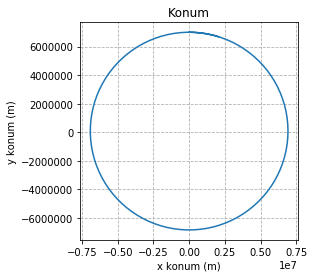

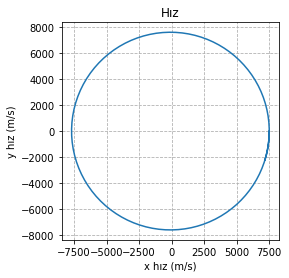

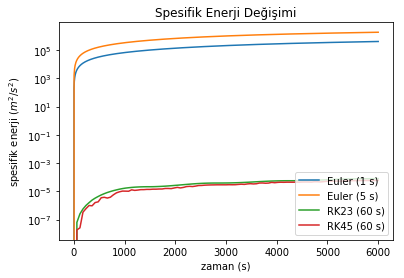

In [32]:
# *********** grafikler ***********

# konum grafiği
plt.plot( [pvt.r[0] for pvt in çözücüPvtList2], [pvt.r[1] for pvt in çözücüPvtList2], label=çözücüTipi2.value + " (" + str(tAdımODE) + " s)")

plt.title("Konum")
plt.xlabel("x konum (m)")
plt.ylabel('y konum (m)')

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show()

# hız grafiği
plt.plot( [pvt.v[0] for pvt in çözücüPvtList2], [pvt.v[1] for pvt in çözücüPvtList2], label=çözücüTipi2.value + " (" + str(tAdımODE) + " s)")

plt.title("Hız")
plt.xlabel("x hız (m/s)")
plt.ylabel("y hız (m/s)")

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show() 

# enerji grafikleri

#referans değer - tüm farklar bu değere göre hesaplanacak
spEnerjiRef = pvt0.spesifikEnerji()

plt.title("Spesifik Enerji Değişimi")
plt.xlabel("zaman (s)")
plt.ylabel("spesifik enerji ($m^2/s^2$)")
plt.yscale('log')

plt.plot( [pvt.t for pvt in eulPvtList1], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList1], label="Euler (" + str(tAdımEuler_2) + " s)")
plt.plot( [pvt.t for pvt in eulPvtList5], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList5], label="Euler (" + str(tAdımEuler_1) + " s)")
plt.plot( [pvt.t for pvt in çözücüPvtList1], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in çözücüPvtList1], label=çözücüTipi1.value + " (" + str(tAdımODE) + " s)")
plt.plot( [pvt.t for pvt in çözücüPvtList2], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in çözücüPvtList2], label=çözücüTipi2.value + " (" + str(tAdımODE) + " s)")

plt.legend(loc=4)

plt.show()


Standart bir RK23 ile geçen sefer enerjiyi 1 saniye adım büyüklüğüne sahip Euler'den 10 kat daha iyi koruduğumuzu söylemiştik. Bu kez sıkı bir adım kontrolü kullanan bir RK45 ile, Euler'e oranla enerjiyi 10,000,000,000 (10 milyar) kez daha iyi koruduk! Bu kadar iyi bir sonucu elde etmek için daha fazla kod yazmamız da gerekmedi zira `scipy` bize tüm bu imkanları hazır olarak sunuyor. RK23 de RK45'e yakın bir performans gösterdi, çünkü sıkı adım kontrolünü ona da uyguladık. Ancak muhtemelen otomatik seçilen adım büyüklükleri RK45'ten daha küçük kaldı; diğer bir deyişle, kullandığımız metod olan RK23, RK45'ten daha kötü olduğu için aynı performansı gösterebilmek için daha çok çalıştı. Gerçek problemlerde, kullanacağımız sayısal integrasyon metodunun seçimi kritik önem teşkil eder. Diferansiyel denklemin bir adımını çözmek için gereken hesaplama kapasitesi, problemin non-lineerliği ve ne kadar ani değişiklikler gösterdiği, problemi ne kadar uzun süre modelleyeceğimiz ile elbette doğruya ne kadar yakın sonuçlar istediğimize bağlı olarak seçeceğimiz matematiksel model değişiklik gösterir. Bu durumda, genellikle farklı modellerle uzun uzadıya performans testleri yaparak en uygun model seçilir.   

Özetle, bu örneğimizde sonunda`numpy` ve `scipy` kütüphanelerine bir başlangıç yaptık ve kod organizasyonu, işlevlerin ayrılması, kodun yeniden kullanımı gibi yazılımcılık zanaatının temel prensiplerinden bahsettik. Bu arada iki cisim gibi basit bir problemin çözümünde bile, fizik kanunları ve matematiksel modeller arasındaki ilişkinin ne kadar çetrefilli olabileceğine kısaca değindik. Son olarak ikinci derece bir diferansiyel denklemin nasıl çözülebileceğine dair de küçük bir örnek yaptık.

Bu yazıyı da, her zamanki gibi, çalıştırılabilir bir Jupyter defteri halinde, yazıdaki iki örneğin kodlarıyla birlikte GitHub sayfamızda bulabilirsiniz.